https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/

### Import and Settings

In [1]:
#library for understanding music
from music21 import *
#for listing down the file names
import os
#Array Processing
import numpy as np
import pandas as pd
#importing library
from collections import Counter
#library for visualiation
import matplotlib.pyplot as plt

import pickle
from sklearn.model_selection import train_test_split

import tensorflow as tf

2023-02-12 15:44:20.973538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 15:44:21.285961: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-12 15:44:21.285995: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-12 15:44:22.124462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Loading Chords from Files:

In [2]:
#specify the path
path='midi_files/'

with open('saved_mido_pickle_files/just_notes-_liszt_mendelssohn_haydn_borodin_balakir_debussy_albeniz_granados_bach_schubert_beeth_chopin_grieg_burgm_brahms_mozart_tscha.pickle', 'rb') as handle:
    loaded_dict = pickle.load(handle)
    
notes_dict = loaded_dict

### EDA

### Preparing Data

In [3]:
notes_dict.keys()

dict_keys(['liszt_1', 'liszt_2', 'liszt_3', 'liszt_4', 'liszt_5', 'liszt_6', 'liszt_7', 'liszt_8', 'liszt_9', 'liszt_10', 'liszt_11', 'liszt_12', 'liszt_13', 'liszt_14', 'liszt_15', 'liszt_16', 'mendelssohn_1', 'mendelssohn_2', 'mendelssohn_3', 'mendelssohn_4', 'mendelssohn_5', 'mendelssohn_6', 'mendelssohn_7', 'mendelssohn_8', 'mendelssohn_9', 'mendelssohn_10', 'mendelssohn_11', 'mendelssohn_12', 'mendelssohn_13', 'mendelssohn_14', 'haydn_1', 'haydn_2', 'haydn_3', 'haydn_4', 'haydn_5', 'haydn_6', 'haydn_7', 'haydn_8', 'haydn_9', 'haydn_10', 'haydn_11', 'haydn_12', 'haydn_13', 'haydn_14', 'haydn_15', 'haydn_16', 'haydn_17', 'haydn_18', 'haydn_19', 'haydn_20', 'haydn_21', 'borodin_1', 'borodin_2', 'borodin_3', 'borodin_4', 'borodin_5', 'borodin_6', 'borodin_7', 'balakir_1', 'debussy_1', 'debussy_2', 'debussy_3', 'debussy_4', 'debussy_5', 'debussy_6', 'debussy_7', 'albeniz_1', 'albeniz_2', 'albeniz_3', 'albeniz_4', 'albeniz_5', 'albeniz_6', 'albeniz_7', 'albeniz_8', 'albeniz_9', 'albeniz

In [4]:
no_of_timesteps = 16
x = []
y = []


for notes in notes_dict.values():
    #print(notes)
    #preparing input and output sequences
    for k in range(0, notes.shape[0]-no_of_timesteps):
        if len(notes) < (k+no_of_timesteps):
            break        
        input_ = notes[k:k+no_of_timesteps]
        output_ = notes[k + no_of_timesteps]
    
        x.append(input_)
        y.append(output_)

x = np.array(x)
y = np.array(y) 

list_x = list((x.flatten().ravel()))
list_y = list((y.flatten().ravel()))

unique_notes = list_x + list_y
unique_notes = sorted(set(unique_notes))

In [5]:
len(x)

638872

In [6]:
#tensor_x = x.reshape(x.shape[0], no_of_timesteps, 1)
#tensor_y = y.reshape(y.shape[0], no_of_timesteps, 1) 

from keras.utils import to_categorical
y_cat      = to_categorical(y)
x_reshaped = x.reshape(x.shape[0],x.shape[1],1)
len(y_cat)

638872

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_reshaped,y_cat,test_size=0.2,random_state=0)
x_val.shape

(127775, 16, 1)

In [9]:
#y_tr      = to_categorical(y_tr)
#y_val     = to_categorical(y_val)
y.shape

(638872,)

In [10]:
print(x_tr.shape)
print(y_tr.shape)
print(x_val.shape)
print(y_val.shape)

(511097, 16, 1)
(511097, 108)
(127775, 16, 1)
(127775, 108)


### Modelling

In [11]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()

input_shape=(no_of_timesteps,1)
model = Sequential([
        #embedding layer
        #Embedding(len(unique_notes), 100, input_length=no_of_timesteps,trainable=True)
    
        Conv1D(filters=64, kernel_size=3, padding='causal',activation='relu', input_shape = (no_of_timesteps,1)),
        Dropout(0.2),
        MaxPool1D(pool_size=1, strides=1),
    
        Dense(units=256, activation='relu'),
            
        Conv1D(filters=64, kernel_size=3, activation='relu', dilation_rate=2, padding='causal'),
        Dropout(0.2),
        MaxPool1D(2),

        #Conv1D(filters=64, kernel_size=3, activation='relu', dilation_rate=2, padding='causal'),
        #Dropout(0.2),
        #MaxPool1D(2),

        Conv1D(filters=256, kernel_size=5, activation='relu'),
        GlobalMaxPool1D(),
    
        Dense(units=256, activation='relu'),
        Dense(units=108, activation='softmax')])
    


model.build(input_shape) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 64)            256       
                                                                 
 dropout (Dropout)           (None, 16, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 16, 256)           16640     
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            49216     
                                                                 
 dropout_1 (Dropout)         (None, 16, 64)            0         
                                                        

2023-02-12 15:44:26.324186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-12 15:44:26.324218: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-12 15:44:26.324237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (elendar-Latitude-E7450): /proc/driver/nvidia/version does not exist
2023-02-12 15:44:26.324432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
mc      = ModelCheckpoint('best_model.h5',
                   monitor='val_loss',
                   mode='min',
                   save_best_only=True,
                   verbose=1)

history = model.fit(np.array(x_tr),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=2, 
                    validation_data=(np.array(x_val),
                                     np.array(y_val)),
                    verbose=1, 
                    callbacks=[mc])

Epoch 1/2


2023-02-12 15:44:26.747663: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 220793904 exceeds 10% of free system memory.


3993/3993 [==============================] - ETA: 0s - loss: 3.3669
Epoch 1: val_loss improved from inf to 5.91110, saving model to best_model.h5
3993/3993 [==============================] - 150s 37ms/step - loss: 3.3669 - val_loss: 5.9111
Epoch 2/2
3993/3993 [==============================] - ETA: 0s - loss: 3.1539
Epoch 2: val_loss did not improve from 5.91110
3993/3993 [==============================] - 139s 35ms/step - loss: 3.1539 - val_loss: 6.3683


In [13]:
history.history

{'loss': [3.3668954372406006, 3.1538963317871094],
 'val_loss': [5.911099433898926, 6.368297100067139]}

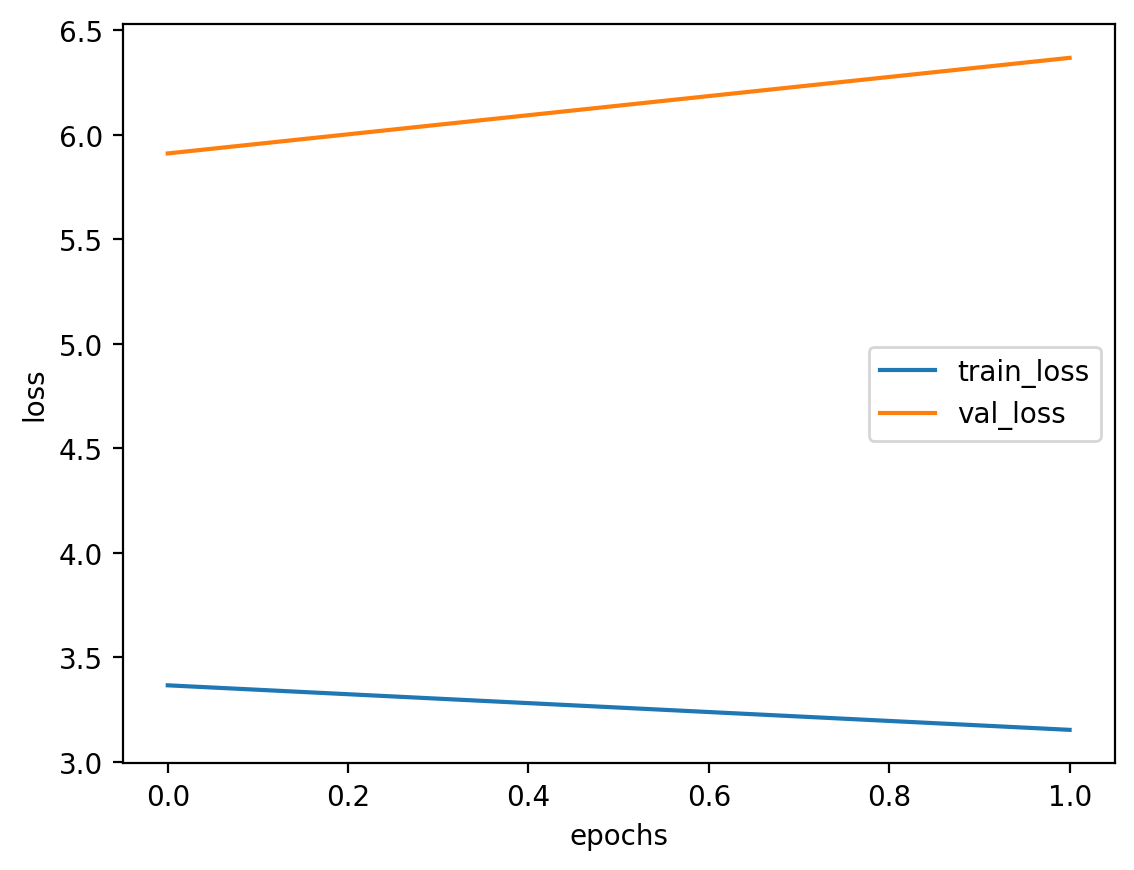

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [15]:
pred = model.predict(x_val)

3993/3993 [==============================] - 15s 4ms/step


In [26]:
x_val[0:2].shape

(2, 16, 1)

In [27]:
pred2 = model.predict(x_val[0:2])

1/1 [==============================] - 0s 21ms/step


In [16]:
pred.shape

(127775, 108)

In [17]:
real_list=[]
pred_list=[]
for count, i in enumerate(pred):
    real_list.append(x_val[count])
    pred_list.append(i.argmax())
len(pred_list), len(real_list)
pred_list[1], real_list[1]

(60,
 array([[86],
        [73],
        [76],
        [64],
        [85],
        [88],
        [71],
        [74],
        [64],
        [83],
        [86],
        [69],
        [73],
        [64],
        [85],
        [81]]))

In [18]:
with open(f'saved_mido_pickle_files/modeL2.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......global_max_pooling1d
.........vars
......max_pooling1d
.........vars
......max_pooling1d_1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File N

In [19]:
music = []
for cnt, i in enumerate(pred):
    music.append(x_val[cnt])
    music[cnt] = np.append(music[cnt],y_val[count].argmax())
    music[cnt] = np.append(music[cnt],i.argmax())


In [20]:
music

[array([75, 77, 73, 77, 73, 73, 70, 75, 72, 78, 75, 77, 78, 77, 73, 76, 63,
        60]),
 array([86, 73, 76, 64, 85, 88, 71, 74, 64, 83, 86, 69, 73, 64, 85, 81, 63,
        60]),
 array([74, 71, 76, 72, 79, 76, 67, 77, 74, 76, 72, 76, 72, 74, 71, 72, 63,
        55]),
 array([54, 56, 53, 54, 51, 55, 56, 57, 58, 59, 60, 49, 37, 56, 49, 61, 63,
        43]),
 array([85, 76, 85, 74, 85, 74, 85, 74, 85, 74, 85, 74, 83, 74, 83, 74, 63,
        60]),
 array([62, 70, 67, 62, 58, 55, 50, 43, 50, 62, 38, 38, 50, 38, 38, 38, 63,
        41]),
 array([52, 59, 50, 60, 48, 53, 48, 41, 54, 50, 42, 57, 50, 45, 56, 51, 63,
        41]),
 array([57, 48, 43, 31, 48, 57, 60, 59, 57, 47, 41, 29, 47, 57, 59, 56, 63,
        48]),
 array([81, 71, 79, 79, 79, 71, 81, 83, 84, 86, 84, 74, 83, 81, 83, 91, 63,
        64]),
 array([34, 41, 49, 34, 41, 49, 34, 41, 49, 34, 41, 49, 32, 41, 49, 32, 63,
        32]),
 array([73, 81, 81, 80, 78, 73, 72, 73, 76, 74, 73, 85, 83, 73, 72, 73, 63,
        60]),
 array([79

In [21]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_notes)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

NameError: name 'predictions' is not defined